<h1 style="font-size:40px;"><center>Exercise II:<br> Convolutional and Recurrent Neural Networks
</center></h1>

## Short summary
In this exercise you will: 

* Train CNNs for a binary classification problem
* Visualize how CNN interprets the data
* Train a CNN for a 3-class classification problem
* Train RNN on a time series prediction problem
* Visualize how RNN hidden node activities
* Sample from a RNN character model
* (Optional) Train a CNN to count corners in polygons. (This problem is defined in another notebook.)

In this lab we will look at network architectures that are designed to handle specific kinds of data. Convolutional Neural Networks for image processing and Recurrent Neural Networks for time series processing

**Deadline for submitting the report: January 7, 12:00 (2020)**

## The data
Digits "5" and "6" from the MNIST database used for a binary classification problem.

A dataset consisting of circles, rectangles or triangles. 

A dataset consisting of pairs of times series. The input time series is a train of rectangle pulses, and the output is triangles, i.e. an up-ramp followed by a down-ramp. For more details see the cell *Ex4-1*. The task is to train a recurrent network that predicts the triangle time series from the pulse time series.

The last exercise is using the Tensorflow source code (C++) represented as a long sequence of characters. See that cell for more details.

## The exercises
As for the previous lab all exercises are found below.

## The different 'Cells'
This notebook contains several cells with python code, together with the markdown cells (like this one) with only text. Each of the cells with python code has a "header" markdown cell with information about the code. The table below provides a short overview of the code cells. 

| #  |  CellName | CellType | Comment |
| :--- | :-------- | :-------- | :------- |
| 1 | Init | Needed | Sets up the environment|
| 2 | Data | Needed | Loading images for the CNN exercise |
| 3 | PlotImg | Information  | View some of the images |
| 4 | Stats | Needed | Compute classification results |
| 5 | Ex1 | Exercise | For question 1-2 |
| 6 | Ex2 | Exercise | For question 3 |
| 7 | Ex3 | Exercise | For question 4 |
| 8 | Ex4-1 | Exercise | For question 5-8 |
| 9 | Ex4-2 | Exercise | For question 5-8 |
| 10 | Ex4-3 | Exercise | For question 5-8 |
| 11 | Ex5-1 | Exercise | For question 9-10 |
| 12 | Ex5-2 | Exercise | For question 9-10 |


In order for you to start with the exercise you need to run all cells with the CellType "Needed". The very first time you start with this exercise we suggest that you enter each of the needed cells, read the cell instruction and run the cell. It is important that you do this in the correct order, starting from the top and work you way down the cells. Later when you have started to work with the notebook it may be easier to use the command "Run All" found in the "Cell" dropdown menu.

## Writing the report
First the report should be written within this notebook. We have prepared the last cell in this notebook for you where you should write the report. The report should contain 4 parts:

* Name:
* Introduction: A **few** sentences where you give a small introduction of what you have done in the lab.
* Answers to questions: For each of the questions provide an answer. It can be short answers or a longer ones depending on the nature of the questions, but try to be effective in your writing.
* Conclusion: Summarize your findings in a few sentences.

It is important that you write the report in this last cell and **not** after each question! When you are ready upload your report to Live@Lund.

## Last but not least
Have fun again!




### CellName: Init (#1)
### CellType: Needed
### Cell instruction: Initializing the libraries
In the cell below, we import all the libraries that are needed for this exercises. There is one configuration parameter that you can change in this cell

* Inline or "pop out" plots.

See comments in the cell for more information. Run the cell by entering into the cell and press "CTRL Enter".


In [1]:
# These two lines is just to avoid some warnings, coming from the fact that we are running
# tensorflow 1.14 and not the latest version.
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import tensorflow as tf
import time
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""

from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Lambda, concatenate
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, RNN

from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Nadam
from tensorflow.keras import backend as K

from sklearn.metrics import *

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# To have the plots inside the notebook "inlin" should be True. 
# If "inlin" = False, then plots will pop out of the notebook
inlin = True # True/False
if inlin:
    %matplotlib inline
else:
    %matplotlib

import matplotlib
import matplotlib.pyplot as plt


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1622895294871762333
]


### CellName: Data (#2)
### CellType: Needed
### Cell instruction: Function for getting images for the CNN exercises

This cell defines the functions that obtain the images needed for the CNN exercise. Note! Later when you actually call these function, if it can't find the files, make sure the "crt-trn/" and "crt-tst/" folders are available in the same directory as this notebook file.

Run the cell by entering into the cell and press "CTRL Enter".

In [2]:
def loadImagesCRT(N=500):
    import imageio
    def load_pics(folder,N):
        imgs = []
        for i in range(N):
            img = imageio.imread(folder+"img_{:05}.png".format(i+1))
            ch = img[:,:,0]
            imgs.append(ch)
        return np.array(imgs)

    def load_labels(fn):
        return np.loadtxt(fn, usecols=(0,1,2))

    base = "./"
    trainpic = load_pics(base + "crt-trn/", N)
    testpic = load_pics(base + "crt-tst/", 1000)
    ntrain, width, height = trainpic.shape

    xtrain = (trainpic/np.float32(255)).reshape(N, width, height, 1)
    xtest = (testpic/np.float32(255)).reshape(1000, width, height, 1)

    ytrain = load_labels(base+"crt-trn_trg.csv")
    ytrain = ytrain[:N]
    ytest = load_labels(base+"crt-tst_trg.csv")

    #xtrain = xtrain[:250]
    
    return xtrain, ytrain, xtest, ytest, width, height


def loadMNIST56():
    xtrain, ytrain, xtest, ytest = np.load("mnist56.npy", allow_pickle=True)
    width, height = xtrain.shape[1:3]
    return xtrain, ytrain, xtest, ytest, width, height


### CellName: PlotImg (#3)
### CellType: Information
### Cell instruction: Show some of the images

Here we look at the first ten pictures in the training set, and their respective targets. You can select the dataset to look at by uncomment the correct line.

Run the cell by entering into the cell and press "CTRL Enter".

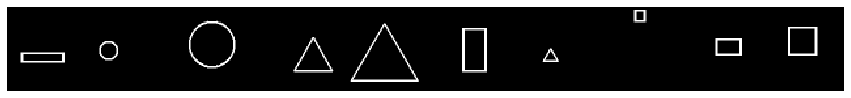

Targets:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [3]:
xtrain, ytrain, xtest, ytest, width, height = loadImagesCRT(10)
#xtrain, ytrain, xtest, ytest, width, height = loadMNIST56()

plt.figure(1, figsize=(15,10))
plt.imshow(xtrain[:10,:,:].swapaxes(0,1).reshape(width,10*height),cmap="gray")
plt.axis("off")
plt.show()

print("Targets:")
print(ytrain[:10])


### CellName: Stats (#4)
### CellType: Needed
### Cell instruction: Get binary and 3-class classification results

This cell just defines functions that we can call to compute som performance measures for binary and 3-class classification problems.

Run the cell by entering into the cell and press "CTRL Enter".

In [4]:
def binary_pred_stats(ytrue, ypred, threshold=0.5):
    one_correct = np.sum((ytrue==1)*(ypred > threshold))
    zero_correct = np.sum((ytrue==0)*(ypred <= threshold))
    sensitivity = one_correct / np.sum(ytrue==1)
    specificity = zero_correct / np.sum(ytrue==0)
    accuracy = (one_correct + zero_correct) / len(ytrue)
    return sensitivity, specificity, accuracy

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.ylim([-0.5, cm.shape[0]-0.5])

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
def multi_stat_3(model = None, x_test = None, y_test = None, lbl = None):
    y_pred = model.predict(x_test, verbose=0 )
    print(lbl,' log_loss:  ', log_loss(y_test, y_pred, eps=1e-15))

    y_true = y_test.argmax(axis=1)
    y_pred = y_pred.argmax(axis=1)
    print(lbl, ' accuracy:  ',(y_pred==y_true).mean(), '\n')

    target_names = ['class {}'.format(i+1) for i in range(3)]

    confuTst = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm           = confuTst, 
                          normalize    = False,
                          target_names = target_names,
                          title        = "Confusion Matrix: " + lbl)


### CellName: Ex1 (#5)
### CellType: Exercise
### Cell instruction: Instructions for question 1-2

## CNN for image classification

In this first exercise you are going to train a CNN that can separate between numbers "5" and "6" from the mnist dataset (mnist56 dataset). We are going to use 2000 training images and 1850 test images. To start with we have a proposed CNN that can solve this problem. It consists of the following:
* First convolutional layer consisting of 4 kernels of size 3x3, with ReLU activation
* Maxpooling of size 2x2
* Second convolutional layer of 4 kernels of size 3x3, with ReLU activation
* Maxpooling of size 2x2
* Special layer *Flatten()*, just transforms the all of the max pooled filter outputs to a linear vector of outputs
* *Dense* layer, meaning a fully connected MLP like layer with 10 nodes, again ReLU activation
* Final output layer consisting of one single output node with sigmoid activation function because we have a binary classification problem.

The default is to use *stride* = 1 and no *padding*. 

#### Question 1
Make sure you understand the definition of the CNN model in the cell below and train it. **What is your test set performance in terms of the accuracy?**

#### Question 2
This image classification problem should be relatively easy since a "5" has some distict differences from a "6". Experiment with the architecture of the CNN model and try to make it smaller, but with the same almost perfect test accuracy. **How many parameters do you have in your trimmed model and state your architecture?**

**Hint:** There is of course very many ways you can make a smaller architecture. You do not need to test all of them!


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 26, 26, 3)         30        
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 13, 13, 3)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 11, 11, 3)         84        
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 5, 5, 3)           0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 380       
_________________________________________________________________
dense_21 (Dense)             (None, 1)               

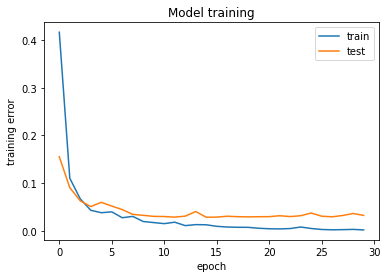

train set: 1.0 1.0 1.0
test set:  0.9916492693110647 0.9932735426008968 0.9924324324324324


In [24]:
# Load the dataset, MNIST-56
xtrain, ytrain, xtest, ytest, width, height = loadMNIST56()

# The size of the images
input_shape = (width, height, 1)

# Define the CNN model
model = Sequential()

# First conv layer
model.add(Conv2D(3, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second conv layer
model.add(Conv2D(3, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fully connected MLP layers
model.add(Flatten())
model.add(Dense(5, activation='relu'))
#model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# We use cross entropy error and the adam optimizer
adam = Adam(lr=0.005)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

# Now train the model
estimator = model.fit(xtrain, ytrain, 
                      validation_data=(xtest, ytest),
                      epochs=30, 
                      batch_size=50,
                      verbose=0)

# Plot the training error
plt.plot(estimator.history['loss'])
plt.plot(estimator.history['val_loss'])
plt.title('Model training')
plt.ylabel('training error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc=0)
plt.show()

# Get the training predictions and results for those
predtrain = model.predict(xtrain)[:,0]
sensitivity, specificity, accuracy = binary_pred_stats(ytrain, predtrain)
print("train set:", sensitivity, specificity, accuracy)

# Get the test predictions and the results for those
predtest = model.predict(xtest)[:,0]
sensitivity, specificity, accuracy = binary_pred_stats(ytest, predtest)
print("test set: ", sensitivity, specificity, accuracy)


### CellName: Ex2 (#6)
### CellType: Exercise
### Cell instruction: Instructions for question 3

You are now going to take a look into the CNN model. There are many attempts to visualize how the CNN model is making classifications. We will here just look at the different filter outputs given an input image. So the code in the cell below will do the following:
* Select an image
* Make a forward pass through the CNN remembering all intermediate values.
* Plot all of the filters for each of the layers.
* One can select to plot before or after the MaxPooling.

This cell relies on the fact that you have run the cell above (Ex1) so that test data has been defined and you have a trained model.

#### Question 3
Train a CNN for the "5" vs "6" provlem! As a suggestion use the following CNN

*3x(3x3 kernel)-maxpool-3x(3x3 kernel)-maxpool-(Flatten)-Dense(5)-Dense(1)*

Make sure that your trained model gives good test results (i.e. > 95% accuracy). Having such a model, you can run the cell below. There are two parameters in the cell, *post_pool* or *idx*. The post_pool variable can be set to *True* meaning that filters will be shown after MaxPooling. The image to show is selected by the *idx* variable. As an example, the following values represent,
* idx=1 number "6"
* idx=2 numner "5"
* idx=3 another number "6"
* idx=5 antoher number "5"

**Can you find some property in the filters that makes sense when it comes to separating "5" from "6"?**

Hint! If you repeat the training you may get new filters!


1.0


<Figure size 1296x864 with 0 Axes>

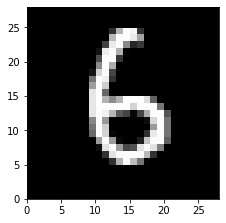

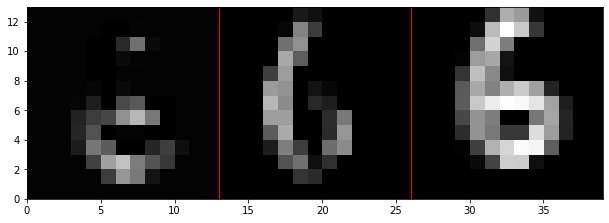

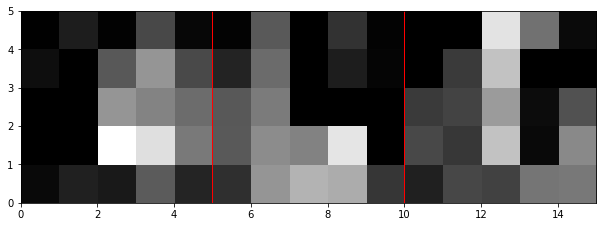

In [29]:
# if True then Maxpooling will be applied before showing the filter
post_pool = True

# The image index to show
idx = 3

kind = MaxPooling2D if post_pool else Conv2D
outs = [l.output for l in model.layers if isinstance(l, kind)]
#outs = [model.layers[0].input] + [l.output for l in model.layers if isinstance(l, kind)]
intermediate = K.function([model.layers[0].input, K.learning_phase()], outs)
print(ytest[idx])
states = [xtest[idx:idx+1]] + intermediate([xtest[idx:idx+1], 0])
#states = intermediate([xtest[idx:idx+1], 0])
plt.figure(figsize=(18,12))                    
for k,s in enumerate(states):
    plt.figure(figsize=(18,12))
    plt.subplot(len(outs)+1,1,k+1)
    #plt.subplot(len(outs),1,k+1)
    pics = s[0]
    pics = np.rollaxis(pics,2,0)
    rows = 2 if pics.shape[0] > 8 else 1
    cols = pics.shape[0]//rows
    imgshape = pics.shape[1:]
    pics = pics.reshape((rows,cols)+imgshape)
    pics = pics.swapaxes(1,2)
    pics = pics.reshape((pics.shape[0]*pics.shape[1], pics.shape[2]*pics.shape[3]))
    extent = (0,cols*imgshape[0], 0,rows*imgshape[1])
    plt.imshow(pics,cmap='gray',extent=extent)
    for r in range(1,rows):
        plt.plot([0,cols*imgshape[0]], [r*imgshape[1], r*imgshape[1]], color='r', linestyle='-', linewidth=1)
    for c in range(1,cols):
        plt.plot([c*imgshape[0], c*imgshape[0]], [0,rows*imgshape[1]], color='r', linestyle='-', linewidth=1)



### CellName: Ex3 (#7)
### CellType: Exercise
### Cell instruction: Instructions for question 4

## CNN for image classification

In this exercise you are going to train a CNN that can separate between circles, squares and triangles, the CRT dataset. We are going to use 500 training images and 1000 test images. Code are provided for loading the data, training the model and presenting the result. Your task is to define the actual CNN model and see how it performs.

#### Question 4
Define your own CNN model for classifying the images in the CRT data into three classes. **Provide the details of your CNN model and present the test result.**

**Hint:** Remember the difference between a binary classifier and a multi-class classifier!

#### Bonus question 
(You do not need to answer this one.) You can run the code in cell #6 also for this model. It will show you the different filter outputs. Again try to understand the features the different filter learn to separate between circles, triangles and rectangles.

In [ ]:
# Load the CRT dataset
xtrain, ytrain, xtest, ytest, width, height = loadImagesCRT()
print('Training data input shape: ', xtrain.shape)
print('Training data output shape: ', ytrain.shape)
print('Test data input shape: ', xtest.shape)
print('Test data output shape: ', ytest.shape)

# The size of the images
input_shape = (width, height, 1)

# Define the CNN model
model = Sequential()

""" 
Put your CNN model here
"""

# We use cross entropy error and the adam optimizer
adam = Adam(lr=0.005)
model.compile(loss='YOUR LOSS FUNCTION', optimizer=adam, metrics=['accuracy'])
model.summary()

# Now train the model
estimator = model.fit(xtrain, ytrain, 
                      validation_data=(xtest, ytest),
                      epochs=30, 
                      batch_size=50,
                      verbose=0)

# Plot the training error
plt.plot(estimator.history['loss'])
plt.plot(estimator.history['val_loss'])
plt.title('Model training')
plt.ylabel('training error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc=0)
plt.show()

multi_stat_3(model,xtest,ytest,'Test')

### CellName: Ex4-1 (#8)
### CellType: Exercise
### Cell instruction: Instructions for question 5-8

## RNN as a pulse converter
We will now look at recurrent networks! This exercise is using divided into three cells below. We start by loading and visualizing the data. **Note!** The actual questions for this part can be found in cell *Ex4-3* below.

### Loading and visualizing the data
The cell below loads the training data and the test data from existing binary python files and plots one set of training/test data, both the input sequence and the target sequence. Run the cell by entering into the cell and press "CTRL Enter".

How is data generated? The input sequence consists of square pulses with varying length and height. The waiting time between the pulses is also varying within some predefined ranges. The lower limit is 2 times the length of the previous pulse. The target triangle pulse sequence is built from the input sequence as follows:
* the triangle pulse start when the input square pulse have ended.
* the width of the triangle (at the base) is twice the width of the square pulse.
* the height of the triangle is the same as the height of the square pulse.

The task is now to learn this mapping using a recurrent neural network. There are 100 input/target sequences in the training data and 100 in the test data.


In [ ]:
# Load data from files
x,y = np.load("rnn_traindata.npy")
xtest,ytest = np.load("rnn_testdata.npy")

# If this is set to True, then we have the reverse problem. Input triangle pulse, target square puls.
if False:
    y,x = x[:,::-1],y[:,::-1]
    ytest,xtest = xtest[:,::-1], ytest[:,::-1]

ns,tlen = x.shape
t = np.arange(tlen)

# The training /validation case to look at
i = 3

# Plot
plt.figure(figsize=(15,10))
plt.subplot(4,1,1)
plt.plot(t,x[i,:])
plt.legend(['Training, input sequence'], loc=0)

plt.subplot(4,1,2)
plt.plot(t,y[i,:])
plt.legend(['Training, target sequence'], loc=0)

plt.subplot(4,1,3)
plt.plot(t,xtest[i,:])
plt.legend(['Test, input sequence'], loc=0)

plt.subplot(4,1,4)
plt.plot(t,ytest[i,:])
plt.legend(['Test, target sequence'], loc=0)


### CellName: Ex4-2 (#9)
### CellType: Exercise
### Cell instruction: Instructions for question 5-8

## RNN as a pulse converter
### define the model and train
Here we are going to setup the model and train it. There are three different models to choose from: 
*SimpleRNN: Simple feedback weights where the output from a node is feeding back to itself. For several hidden nodes there are feedback weights to all other nodes in the layer.
* LSTM: The LSTM unit
* GRU: The GRU unit

The standard choice of activation function is *tanh*, but you can also test *relu*. When it comes to training this model we are goint to use a possible truncated BPTT approach. The support in Keras for doing this is somewhat limited so here it is implemented manually. In short we have 100 training sequences and we define a mini-batch size *mb* that selects *mb* of these sequences to train using the normal stochastic gradient descent idea. Then we have a variable *batchlen* that is the length of the sequence to use in truncated BPTT. The default values for these are *mb=10* and *batchlen=50*. If you want to train without the truncated BPTT approach put *batchlen=100*.

During training we print the normalized training and test error. Normalized means here that the loss (=MSE) is divided by the variance of the target signal. So that a normalized error of 1 is not so good, but if we get below 0.1 (or so) it means that the error is much smaller than the signal itself.

What you need to do in this cell is to define your model and train it.

In [ ]:
%%time
ns,tlen = x.shape

# Parameters defining the mini-batch size and 
# the sequence length for truncated BPTT
mb = 10
nmb = ns//mb
batchlen = 50
ntsteps = tlen//batchlen

# The network type
net = SimpleRNN
#net = GRU
#net = LSTM

# Number of hidden nodes
nh1 = 5

# This is only if you would like to add an additional hidden layer. See below.
nh2 = 5

# The activation function
activation = 'tanh'
#activation = 'relu'

# The number of epochs
nE = 20

#Start defining the model
model = Sequential()
model.add(net(nh1, 
              batch_input_shape=(mb,batchlen,1), 
              stateful=True, 
              return_sequences=True, 
              activation=activation))

# Uncomment this line if you want to add an additional hidden layer
#model.add(net(nh2, stateful=True, return_sequences=True, activation=activation))

model.add(TimeDistributed(Dense(1)))

adam = Adam(lr=0.003)
model.compile(optimizer=adam,loss='mean_squared_error')
model.summary()

# Now the training part
trnTrgVar = np.var(y[:,:])        # Variance for train target signal
testTrgVar = np.var(ytest[:,:])   # Variance for test target signal
ndone = 0

print('Epoch', 'Time/Epoch', ' Train-Err', '  Test-Err')
for ne in range(nE):
    t0 = time.time()
    sumloss = 0
    for batch in range(nmb):
        i1,i2 = batch*mb,(batch+1)*mb
        model.reset_states()
        for tstep in range(ntsteps):
            t1,t2 = tstep*batchlen,(tstep+1)*batchlen
            loss = model.train_on_batch(x[i1:i2,t1:t2,None], y[i1:i2,t1:t2,None])
            sumloss += loss
    meanloss = sumloss/(nmb*ntsteps)

    # Test error
    sumlossvalid = 0
    for batch in range(nmb):
        i1,i2 = batch*mb,(batch+1)*mb
        model.reset_states()
        for tstep in range(ntsteps):
            t1,t2 = tstep*batchlen,(tstep+1)*batchlen
            loss = model.evaluate(xtest[i1:i2,t1:t2,None], ytest[i1:i2,t1:t2,None],batch_size=mb,verbose=0)
            sumlossvalid += loss
    meanlossvalid = sumlossvalid/(nmb*ntsteps)
    t1 = time.time()
    ndone += 1
    print(ndone, "    {:.2f}        {:.5f}     {:.5f}".format(t1-t0, meanloss/trnTrgVar, meanlossvalid/testTrgVar))


### CellName: Ex4-3 (#10)
### CellType: Exercise
### Cell instruction: Instructions for question 5-8

## RNN as a pulse converter
### Plot the result
In this cell we just plot the result for one of the first 10 test sequences. You can select which of these ones by an index (see the code). Also, the last graph shows the hidden node activation for all of the hidden nodes. **Note:** For the GRU and simpleRNN models this all of the hidden activity there is, but for the LSTM there is also the memory signal. This one is not shown!

### Questions
We are now finally at the point of asking questions. Whenever you define a new model and train it, you need to run the  cell below in order to show the result for the newly trained model. 

**Hint!** For all of the questions below you are going to train different models. Keep an eye on how the training error is developing. If you see large fluctuations, you may to change the learning rate. The default value of 0.003 should be OK for most trainings. 

#### Question 5
(Just to get started!) Define a simpleRNN model with 5 hidden nodes and train it for about 20 epochs. **What test error do you obtain?** 

Hint: The test error can be found during "training" as the error for the last epoch.
Hint: You may have to train a couple of times to make sure that you did not end up in a "bad" local minima the first time.

#### Question 6
Test different models! Train three different models with the same number of hidden nodes (e.g. 4) and decide which of them that works best? **So, out of the three different models, *simpleRNN, GRU och LSTM*, which one worked best using the same number of hidden nodes?**

Comment: Of course the different models uses different amount of weights, so one can argue that it is not a fair comparison!

#### Question 7
Interpretation! You are now going to interpret the hidden node outputs. Remember that the actual output for each time is just a linear combination of the hidden node outputs. As said before you can see the hidden nodes output in the last plot. Note that the weights in the dense layer can have different signs so that hidden nodes outputs can be linearly combined with both positve and negatives signs. Train a *GRU* model with 3 hidden nodes for about 20 epochs. **Try to explain what the different hidden nodes are actually detecting**.

Comment: This is of course a question with no definite true answer. We just want you to interpret what the different nodes are doing.

#### Question 8
If you look at the top of cell *Ex4-1* you can, by changing False -> True, define the reverse problem. That is, input is the triangle pulse and target is the square pulse. This should be a more difficult problem! **Why?** **Present a RNN model that can "solve" this reverse problem (i.e. below 0.1 in test error).**


In [ ]:
xshow = xtest[:mb]
yshow = ytest[:mb]
yout = np.zeros((mb,tlen))
hidden1 = np.zeros((mb,tlen,nh1))
hidden2 = np.zeros((mb,tlen,nh2))

rnn1 = model.layers[0]
rnn2= model.layers[1]

#dense = model.layers[-1]
#sign = K.sign(dense.layer.kernel)[None,None,:,0]
if len(model.layers) > 2 :
    intermediate = K.function([rnn1.input], [rnn1.output, rnn2.output ])
else :
    intermediate = K.function([rnn1.input], [rnn1.output])

for tstep in range(ntsteps):
    t1,t2 = tstep*batchlen,(tstep+1)*batchlen
    inp = xshow[:,t1:t2,None]
    if len(model.layers) > 2 :
        hi,hi2 = intermediate([inp])
        hidden2[:,t1:t2:,:] = hi2
    else :
        hi, = intermediate([inp])
    hidden1[:,t1:t2:,:] = hi
    yi = model.predict(xshow[:,t1:t2,None])
    yout[:,t1:t2] = yi[:,:,0]

t = np.arange(tlen)

# Selection of test sequnce. i=0 is rather easy, i=1 is a difficult one
i = 1

plt.figure(figsize=(15,10))

plt.subplot(4,1,1)
plt.plot(t,xshow[i],'-',marker='.')
plt.legend(['Training, input sequence'], loc=0)

plt.subplot(4,1,2)
plt.plot(t,yshow[i],'-',marker='.')
plt.plot(t,yout[i],'-',marker='.')
plt.legend(['Test, target sequnce', 'Test, predicted sequence'], loc=0)

plt.subplot(4,1,3)
plt.plot(t,hidden1[i],'-',marker='.')
plt.title('Hidden 1 node outputs')

if len(model.layers) > 2 :
    plt.subplot(4,1,4)
    plt.plot(t,hidden2[i],'-',marker='.')
    plt.title('Hidden 2 node outputs')

### CellName: Ex5-1 (#11)
### CellType: Exercise
### Cell instruction: Instructions for question 9-10

## RNN: Sampling from a character model
As a final exercise we are going to look into an example where a recurrent network is used to predict a sequence of characters. The model is autoregressive, meaning that the previous values $\ldots, x_{i-2}, x_{i-1}$ is used to predict $x_i$. In the model characters are represented as vectors with the same number of elements as the number of unique characters in the sequence. The input in each sequence step is a single character, represented using "one-hot" coding, that is exactly one vector element is one, representing that particular character. The output is on the other hand a probability vector over all characters, which can be used to sample a character from the predictive distribution. To sample long sequences of characters, we feed one sampled character back into the network, to predict the character after that and so on.

The sequence of characters that we are going to train on is the source code of Tensorflow (C++). The size of the downloaded source code is approximately 14 Mb, which means about 14 million characters in the sequence. The number of unique characters is 103. Therefore the output layer consists of 103 nodes with a softmax activation function. The RNN model itself is rather large, it consists of two layers of 1024 LSTM nodes in each layer. In addition to that there are skip-layer connections from input to second hidden layer and skip connections from first hidden layer to the output layer. In total there are about 13.5 million weights in this model.

This model take too long time to train as part of this lab. It takes days rather than minutes to train! Therefore pre-trained weights are handed out as part of the lab material. This is the file that you needed to download from an external URL!

Given such a model we can now "sample" from it. Given some initial sequence of characters, as a seed, we can run the model for a number of sequence steps in order to find the sequence of predicted characters. But we can do more! Since the output is a vector of probabilities for new characters we can sample from it. As an example assume we only have 5 characters in our vocabulary and the prediction for a new character is:

(0.1, 0.3, 0.5, 0.0, 0.1)

So the character represented by the third position would be selected since it has the largest probability. But if we treat these number as probabilities we can say that half of the times we are going to select the third character, 30% of the time we select the character represented by the second position and so on. To even make things more random we can modify these probabilities such that they become more equal (high temperature) or that the largest probability becomes even larger (small temperature). This temperature parameter *temp* can be changed so that the sampling becomes completely random (very high *temp*) or completely deterministic (very low *temp*).

The code cell below just defines the model and loads the pre-trained weights onto the model. Run the cell! It can take some seconds to do that!


In [ ]:
# set of all chars appearing in tensorflow source code:
chars = ['\t', '\n'] + [chr(x) for x in range(32,127)] + ['°', 'θ', 'μ', 'ν', '’', '\ufeff']
char_indices = dict((c, i) for i, c in enumerate(chars))

# build the model: two layers of LSTM
nh = 1024
arch = LSTM
inp = Input(batch_shape=(1, 1, len(chars)))
h1layer = arch(nh, return_sequences=True, stateful=True)
h2layer = arch(nh, stateful=True)
is_skip = True
h1 = h1layer(inp)
i2 = concatenate([inp, h1])
h2 = h2layer(i2)
h1last = Lambda(lambda h: h[:,-1,:])(h1)
rnnout = concatenate([h1last, h2])
beta_var = K.variable(1.0)
d = Dense(len(chars))(rnnout)
d = Lambda(lambda d: d * beta_var)(d)
out = Activation('softmax')(d)
m = Model([inp], [out])
m.compile(loss='categorical_crossentropy', optimizer='adam')
m.summary()

# Load the weights
m.load_weights("charmodel.h5")


### CellName: Ex5-2 (#12)
### CellType: Exercise
### Cell instruction: Instructions for question 9-10

## RNN: Sampling from a character model
In the cell below a function is defined that perform the actual sampling. It takes three parameters as input. (i) the starting sequence *seed*, (ii) the length of the sequence to generate *seqLen* and (iii) the temperature used during sampling *temp*. 

#### Question 9
Run the cell below with the given parameters. **Does it look like C++ code?**

#### Question 10
Change the seed to something else! **What happens when you decrease/increase the temperature (e.g 0.7-1.5)?**


In [ ]:
def sampletxt(seed=" ", n=50, t=1.0):
    m.reset_states()
    K.set_value(beta_var, 1/t)

    for c in seed:
        x_pred = np.zeros((1, 1, len(chars)))
        x_pred[0, 0, char_indices[c]] = 1.
        p = m.predict(x_pred, verbose=[0])
        
    txt = []
    for i in range(n):
        preds = p[0].astype('float64')
        preds = preds/np.sum(preds) # some numericol issue
        probas = np.random.multinomial(1, preds, 1)
        next_index = np.argmax(probas)
        txt.append(chars[next_index])
        p = m.predict(probas[None,:,:], verbose=0)

    return ''.join(txt)

#seed = " "
#seed = "void "
seed = "for (int"
seqLen = 500
temp = 1.0

print(seed + sampletxt(seed,seqLen,temp))


# The report!


### Name

Daniel Magdalinski

### Introduction



### Answers to questions

Question 1:

test set:  0.9916492693110647 0.9943946188340808 0.9929729729729729

Question 2: 

conv2d_2 (Conv2D)            (None, 26, 26, 2)         20        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 2)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 2)         38        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 2)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        

Total params: 579
Trainable params: 579
Non-trainable params: 0

test set:  0.9843423799582464 0.9977578475336323 0.9908108108108108

conv2d_6 (Conv2D)            (None, 25, 25, 2)         34        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 2)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 9, 9, 2)           66        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 2)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                330       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        

Total params: 441
Trainable params: 441
Non-trainable params: 0
______________________________

test set:  0.9926931106471816 0.9876681614349776 0.9902702702702703

conv2d_10 (Conv2D)           (None, 25, 25, 2)         34        
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 2)           0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 5, 5, 2)           66        
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 1, 1, 2)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 7)                 21        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 8         

Total params: 129
Trainable params: 129
Non-trainable params: 0

test set:  0.988517745302714 0.9820627802690582 0.9854054054054054

conv2d_14 (Conv2D)           (None, 25, 25, 2)         34        
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 12, 12, 2)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 9, 9, 2)           66        
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 3, 3, 2)           0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 18)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 7)                 133       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 8         

Total params: 241
Trainable params: 241
Non-trainable params: 0

test set:  0.9853862212943633 0.9966367713004485 0.9908108108108108

### Summary
  